In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#!pip install ann_visualizer
# Libraries for Images
import os
import json
import glob
from PIL import Image

# Libraries for Evaluations and Train/Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
#!pip install keras-tuner
#import keras_turner
from keras_tuner.tuners import BayesianOptimization

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


#ResNET
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#Statistical Test
from scipy.stats import ttest_rel
from sklearn.metrics import accuracy_score
from scipy.stats import binom

#Evaluation
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#Model Visualization
from ann_visualizer.visualize import ann_viz
from tensorflow.keras.utils import plot_model


#Others
from tqdm import tqdm  # Optional: tqdm for progress bar
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from itertools import combinations

from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model

#Own functions
import sys
from Own_Functions.k_fold_utils import k_fold_cross_validation
from Own_Functions.compare_models import compare_models
from Own_Functions.compare_model_performance import compare_model_performance
from Own_Functions.check_compile import check_compile
from Own_Functions.count_images_in_subfolders import count_images_in_subfolders
from Own_Functions.evaluate_model import evaluate_model
from Own_Functions.save_results_to_json import save_results_to_json
from Own_Functions.save_history_to_json import save_history_to_json
from Own_Functions.subgenerator_utils import create_subgenerator 
from Own_Functions.plot_metric_across_folds import plot_metric_across_folds 
from Own_Functions.plot_comparison_across_folds import plot_comparison_across_folds 
from Own_Functions.load_results_from_json import load_results_from_json
from Own_Functions.compare_models_extended import compare_models 
from Own_Functions.perform_and_compare_t_test import perform_and_compare_t_test 
from Own_Functions.sign_test import sign_test 
from Own_Functions.sign_test_table import sign_test_table 
from Own_Functions.k_fold_parallel_utils import k_fold_cross_validation_parallel



In [2]:
# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/'
image_overview = count_images_in_subfolders(root_folder_path)

image_overview

,Classes,Number_Images
0,paper,1050
1,green-glass,629
2,clothes,5325
3,metal,769
4,cardboard,891
5,trash,697
6,biological,985
7,white-glass,775
8,battery,945
9,brown-glass,607


In [3]:
image_overview['Number_Images'].sum()

15515

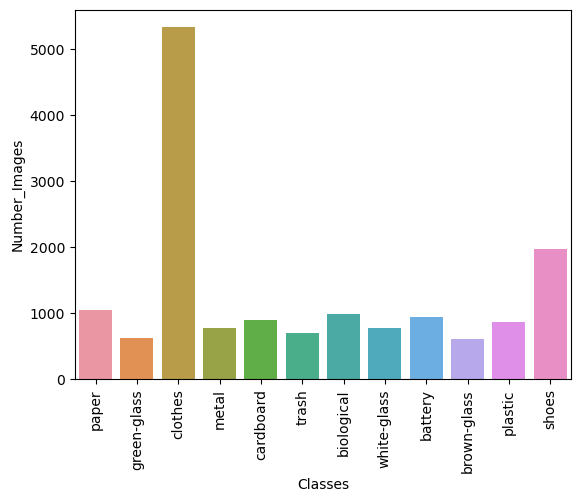

In [4]:
sns.barplot(image_overview, x="Classes", y="Number_Images")
plt.xticks(rotation=90)
plt.show()

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pfad zum Hauptverzeichnis der Daten
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Liste zum Speichern der Dateipfade und Labels
file_paths = []
labels = []

# Durchlaufen aller Unterverzeichnisse und Sammeln der Dateipfade und Labels
for class_name in os.listdir(root_folder_path):
    class_dir = os.path.join(root_folder_path, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_name, file_name))
            labels.append(class_name)

# Umwandlung der Listen in Arrays für die weitere Verarbeitung
file_paths = np.array(file_paths)
labels = np.array(labels)

# Aufteilen der Daten in Training+Validierung und Test
file_paths_train_val, file_paths_test, labels_train_val, labels_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Aufteilen der Trainings- und Validierungsdaten
file_paths_train, file_paths_val, labels_train, labels_val = train_test_split(
    file_paths_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)

# Erstellen eines DataFrames für das Training
df_train = pd.DataFrame({'filepath': file_paths_train, 'label': labels_train})

# StratifiedShuffleSplit zur Erstellung eines Subsets mit 3000 Bildern
sss = StratifiedShuffleSplit(n_splits=1, test_size=3000, random_state=42)
for _, subset_index in sss.split(df_train['filepath'], df_train['label']):
    df_subset = df_train.iloc[subset_index]

# Initialisieren des ImageDataGenerator für das Training mit Augmentierung
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Erstellen des Trainingsdatengenerators für das vollständige Trainingset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Erstellen des Trainingsdatengenerators für das Subset für Cross-Validation
train_cross_validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_subset,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Für Validierung und Test ohne Augmentierung, nur Reskalierung
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Validierungsdatengenerator
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': file_paths_val, 'label': labels_val}),
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Testdatengenerator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': file_paths_test, 'label': labels_test}),
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Wichtig, um die Reihenfolge bei der Bewertung zu erhalten
)

Found 9309 validated image filenames belonging to 12 classes.
Found 3000 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.


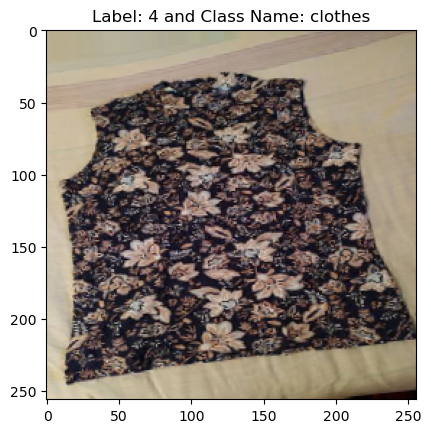

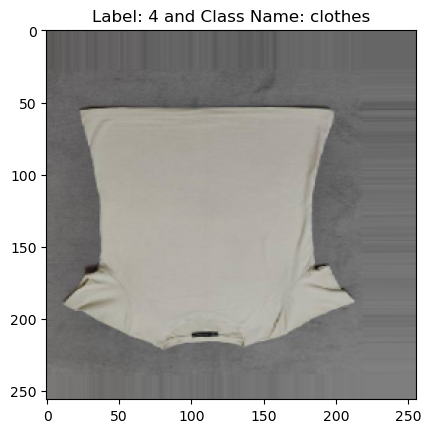

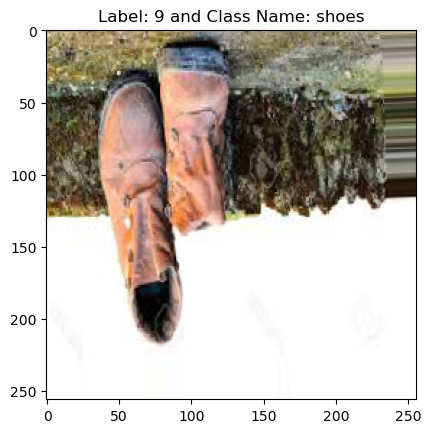

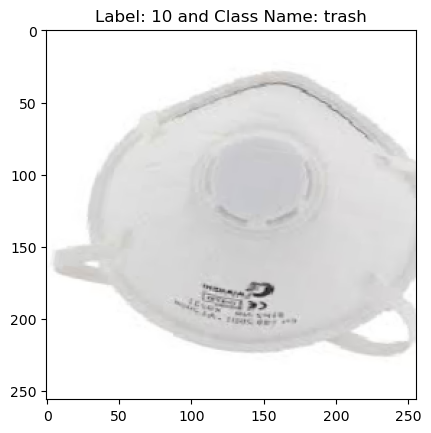

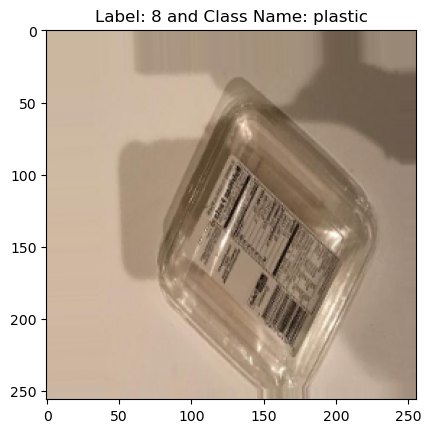

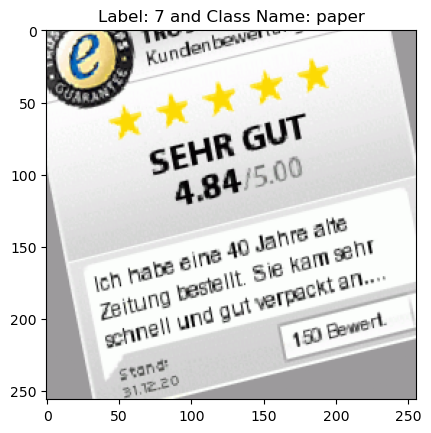

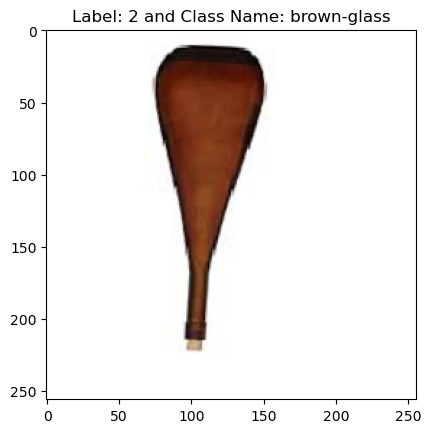

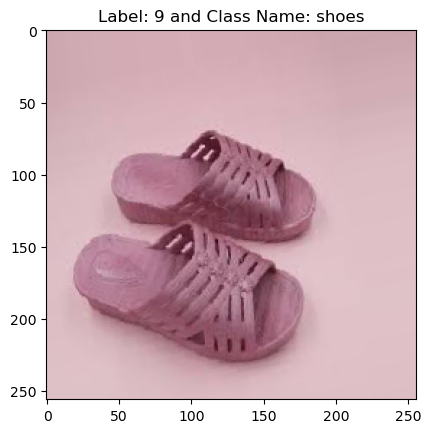

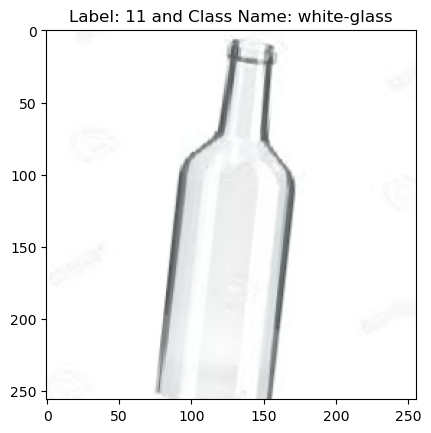

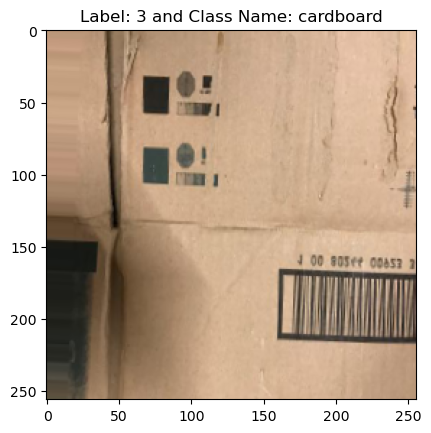

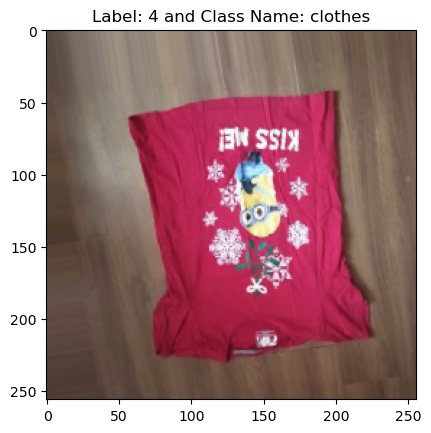

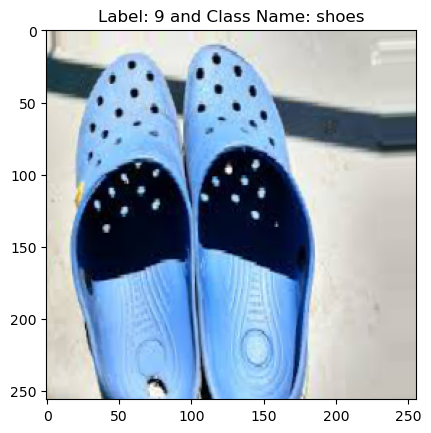

In [6]:
# Get a batch from the training generator
class_names = list(train_generator.class_indices.keys())
#print("Class Names:", class_names)
batch_images, batch_labels = next(train_generator)

# Visualize the first few images in the batch
num_images_to_visualize = 12
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    class_name = class_names[label_index]
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label_index} and Class Name: {class_name}")
    plt.show()

In [7]:
class_counts = dict(zip(test_generator.class_indices, np.bincount(test_generator.classes)))
class_counts

{'battery': 189,
 'biological': 197,
 'brown-glass': 122,
 'cardboard': 178,
 'clothes': 1065,
 'green-glass': 126,
 'metal': 154,
 'paper': 210,
 'plastic': 173,
 'shoes': 395,
 'trash': 139,
 'white-glass': 155}

<IPython.core.display.Javascript object>

NameError: name 'notebook_name' is not defined

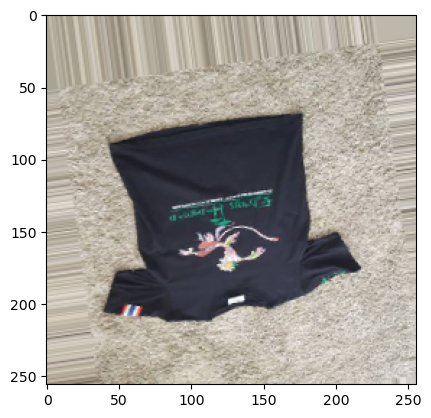

In [8]:
from IPython.display import display, Javascript

def get_notebook_name():
    js = Javascript('''
        IPython.notebook.kernel.execute("notebook_name = '" + IPython.notebook.notebook_name + "'");
    ''')
    display(js)

get_notebook_name()

# Nun der Rest Ihres Codes
import numpy as np
import matplotlib.pyplot as plt

# Get a batch from the training generator
class_names = list(train_generator.class_indices.keys())
batch_images, batch_labels = next(train_generator)

# Visualize the first few images in the batch
num_images_to_visualize = 12
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    class_name = class_names[label_index]
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label_index}, Class Name: {class_name}, Notebook: {notebook_name}")
    plt.show()


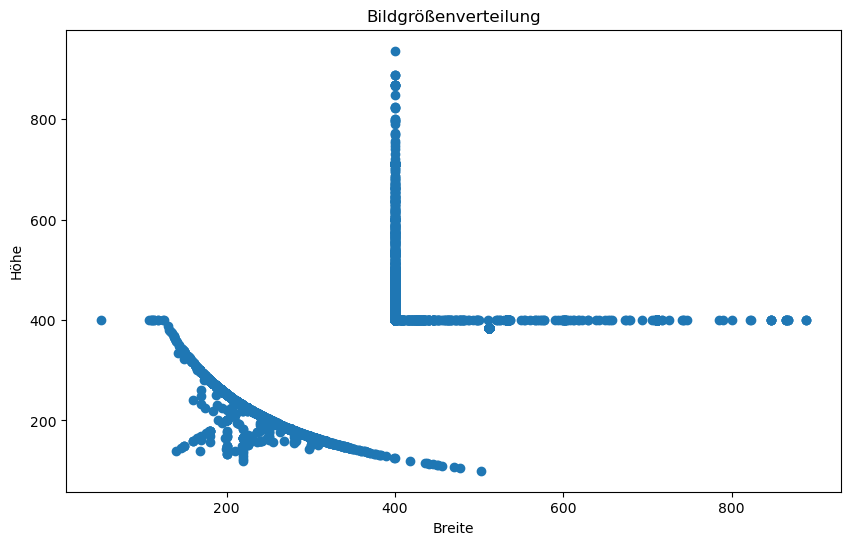

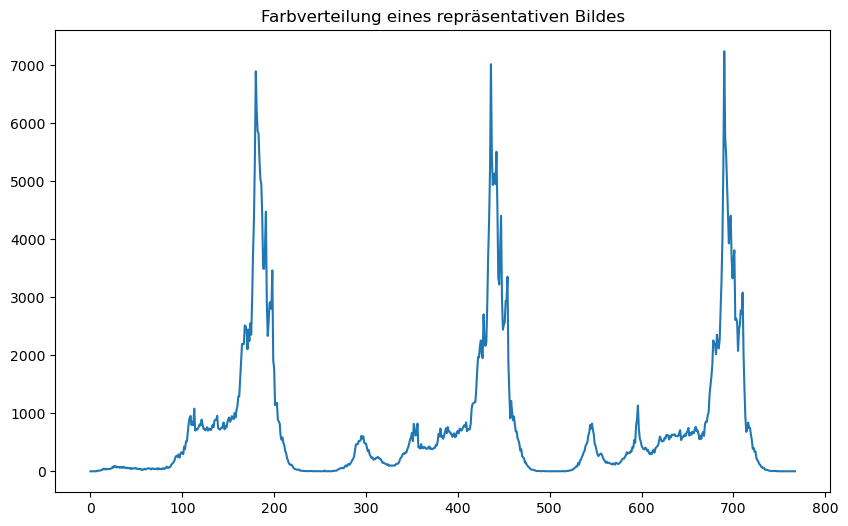

Die durchschnittliche Bildgröße ist {349.8223009990332}


In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/'

# Sammeln Sie Informationen über die Bilder
image_sizes = []
color_distributions = []

for subdir, dirs, files in os.walk(root_folder_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(subdir, file)
            with Image.open(file_path) as img:
                # Größe des Bildes
                image_sizes.append(img.size)
                
                # Farbspectrum des Bildes (Histogramm)
                color_distributions.append(img.histogram())
                
                # Hier könnten Sie weitere Analysen durchführen, z.B. Auffälligkeiten erkennen

# Visualisieren Sie die Größenverteilung der Bilder
widths, heights = zip(*image_sizes)
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights)
plt.title('Bildgrößenverteilung')
plt.xlabel('Breite')
plt.ylabel('Höhe')
plt.show()

# Farbverteilung (Histogramm) für ein repräsentatives Bild anzeigen
plt.figure(figsize=(10, 6))
plt.plot(color_distributions[0])
plt.title('Farbverteilung eines repräsentativen Bildes')
plt.show()

# Mittlere Bildgröße
mean_width = np.mean(widths)
mean_height = np.mean(heights)
print(f'Die durchschnittliche Bildgröße ist', {mean_width})


In [13]:
import os
import numpy as np
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
from scipy import ndimage

# Pfad zum Wurzelverzeichnis, in dem sich die Bilder befinden

# Speichern Sie die Bildcharakteristika
resolutions = []
color_depths = []
textures = []
color_histograms = []
noise_levels = []

for subdir, dirs, files in os.walk(root_folder_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(subdir, file)
            with Image.open(file_path) as img:
                # Auflösung und Größenverteilung
                resolutions.append(img.size)
                
                # Farbtiefe
                color_depths.append(img.mode)
                
                # Bild in Array konvertieren
                img_array = np.array(img)
                
                # Histogramm der Farben und Intensitäten
                for i in range(3):  # RGB-Kanäle
                    hist, bins = np.histogram(img_array[..., i], bins=256, range=(0, 256))
                    color_histograms.append((hist, bins))
                
                # Texturinformationen
                gray_img = img.convert('L')  # Umwandeln in Graustufen
                gray_array = np.array(gray_img)
                textures.append(ndimage.variance(gray_array))
                
                # Rauschen ermitteln
                noise = ImageStat.Stat(gray_img).stddev[0]
                noise_levels.append(noise)



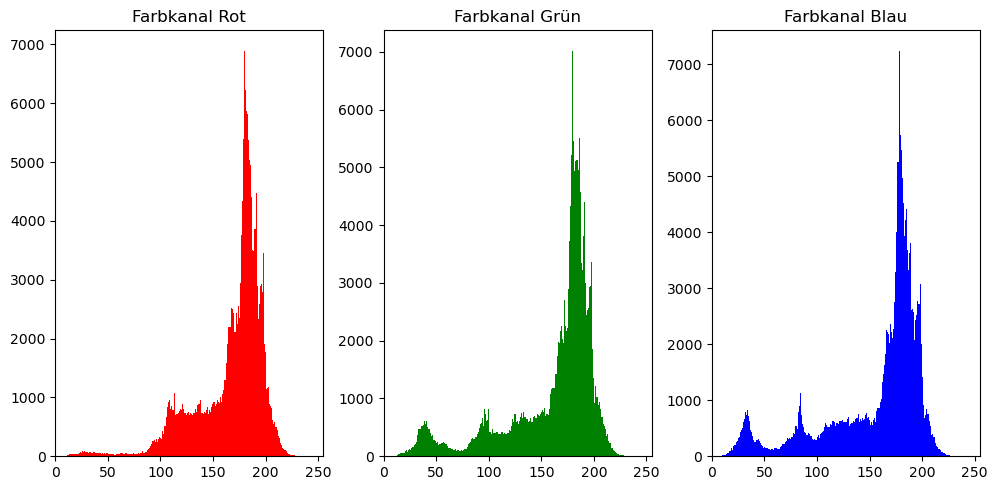

In [14]:
# Histogramme der Farben und Intensitäten plotten
plt.figure(figsize=(10, 5))
for i, (hist, bins) in enumerate(color_histograms[:3]):  # Nur das erste Bild als Beispiel
    plt.subplot(1, 3, i+1)
    plt.bar(bins[:-1], hist, width=1, color=['r', 'g', 'b'][i])
    plt.title(f"Farbkanal {['Rot', 'Grün', 'Blau'][i]}")
    plt.xlim(0, 255)
plt.tight_layout()
plt.show()

In [16]:
# Durchschnittliche Auflösung
average_resolution = np.mean(resolutions, axis=0)
print(f"Durchschnittliche Auflösung: {average_resolution}")

max_resolution = np.max(resolutions, axis=0)
print(f"Maximale Auflösung: {max_resolution}")

min_resolution = np.min(resolutions, axis=0)
print(f"Minimale Auflösung: {min_resolution}")


Durchschnittliche Auflösung: [349.822301   351.70583306]
Maximale Auflösung: [888 936]
Minimale Auflösung: [ 51 100]


In [17]:
# Farbtiefenverteilung
color_depth_distribution = {depth: color_depths.count(depth) for depth in set(color_depths)}
print(f"Farbtiefenverteilung: {color_depth_distribution}")





Farbtiefenverteilung: {'P': 34, 'RGB': 15481}


In [22]:
# Durchschnittliche Texturinformationen
average_texture = np.mean(textures)
print(f"Durchschnittliche Texturvarianz: {average_texture}")

max_texture = np.max(textures)
print(f"Maximale Texturvarianz: {max_texture}")

min_texture = np.min(textures)
print(f"Minimale Texturvarianz: {min_texture}")

Durchschnittliche Texturvarianz: 3282.9557818306844
Maximale Texturvarianz: 14003.580758291626
Minimale Texturvarianz: 7.378934967152862


In [25]:
# Durchschnittliches Rauschniveau
average_noise = np.mean(noise_levels)
print(f"Durchschnittliches Rauschniveau: {average_noise}")

max_noise = np.max(noise_levels)
print(f"Maximales Rauschniveau: {max_noise}")

min_noise = np.mean(noise_levels)
print(f"Minimales Rauschniveau: {min_noise}")



Durchschnittliches Rauschniveau: 53.92519665697075
Maximales Rauschniveau: 118.33672616010477
Minimales Rauschniveau: 53.92519665697075


In [21]:

# Anomalien und Ausreißer - hier könnten Sie z.B. sehr hohe oder sehr niedrige Rauschwerte identifizieren
noise_threshold = average_noise + 2 * np.std(noise_levels)  # 2 Standardabweichungen
outliers = [noise for noise in noise_levels if noise > noise_threshold]
print(f"Identifizierte Rauschanomalien: {len(outliers)}")

Identifizierte Rauschanomalien: 412


In [26]:
412/15515

0.026554946825652594

In [27]:
noise_threshold

92.65652492429027

In [28]:
np.std(noise_levels)

19.365664133659756